In [1]:
# IMPORTANT OLD VERSION!! DON'T DELETE!
#     # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
#     for query_id, query_terms in tokenized_queries.items():
        
#         if (int(query_id) - 50) % 15 == 0:
#             print('Finished {}%...'.format((int(query_id) - 50) / 15 * 10))
            
#         document_score = defaultdict(float)
        
#         for query_term_id in query_terms:
#             for int_doc_id in inverted_index[query_term_id]:
#                 ext_doc_id = index.document(int_doc_id)
#                 document_term_freq = inverted_index[query_term_id][int_doc_id]
#                 document_score[ext_doc_id] += score_fn(int_doc_id, query_term_id, document_term_freq)
                
#         query_result = [(doc_score, ext_doc_id) for ext_doc_id, doc_score in document_score.items()]
#         data[query_id] = query_result

# IMPORTANT OLD VERSION!! DON'T DELETE!
# import numpy as np

# def tfidf(int_document_id, query_term_id, document_term_freq):
#     """
#     Scoring function for a document and a query term
    
#     :param int_document_id: the document id
#     :param query_token_id: the query term id (assuming you have split the query to tokens)
#     :param document_term_freq: the document term frequency of the query term 
#     """
#     tf = document_term_freq/document_lengths[int_document_id]
#     df = len(inverted_index[query_term_id])
#     idf = num_documents/df
#     score = np.log(1 + tf) * np.log(idf)
#     return score

# # combining the two functions above: 
# run_retrieval('tfidf', tfidf)

# # TODO implement the rest of the retrieval functions 

# # TODO implement tools to help you with the analysis of the results.

# Searching Unstructured and Structured Data #
## Assignment 1: Retrieval models [100 points] ##
**TA**: Nikos Voskarides (n.voskarides@uva.nl)

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [2]:
import logging
import sys
import os
import numpy as np
def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

In [3]:
# %%bash
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run > trec_results_tdfidf
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run > trec_results_tdfidf
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run > trec_results_tdfidf
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run > trec_results_tdfidf

# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run  | grep -E "^map_cut_1000" > map_cut_1000
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run  | grep -E "^ndcg_cut_10\s" > ndcg_cut_10
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run  | grep -E "^P_5\s" > P_5
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run  | grep -E "^recall_1000\s" > recall_1000
# ./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel tfidf.run 

In [4]:
# %matplotlib
# import matplotlib.pyplot as plt

# y = np.array(list(document_lengths.values()))
# x = np.arange(len(y))
# print(sorted(y))
# plt.plot(y, x)
# plt.show()

In [5]:
# print([len(results[a]) for a in results])
# print([(i, results[i]) for i in measures])

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [6]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [7]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [8]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [9]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [10]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [11]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [12]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [13]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [14]:
import time

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')
start_time = time.time()
num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

#TODO: Explain why we need it
query_term_counts = {
    query_id: collections.Counter(query_terms) 
    for query_id, query_terms in tokenized_queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
inverted_index_positions = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

document_ids = []
for int_doc_id in range(index.document_base(), index.maximum_document()):
    # CHECK IF WE CAN DO THAT
    if len(index.document(int_doc_id)[1]) > 0:
        document_ids.append(int_doc_id)
        ext_doc_id, doc_token_ids = index.document(int_doc_id)
        doc_token_ids = [doc_token_id for doc_token_id in doc_token_ids if doc_token_id > 0]
        
        document_bow = collections.Counter(doc_token_ids)

        token_positions = collections.defaultdict(list)

        # Check with the TAs if we can change that
        [token_positions[token_id].append(i) for i, token_id in enumerate(doc_token_ids)]

        document_length = sum(document_bow.values())

        document_lengths[int_doc_id] = document_length
        total_terms += document_length

        unique_terms_per_document[int_doc_id] = len(document_bow)

        for query_term_id in query_term_ids:
            assert query_term_id is not None

            document_term_frequency = document_bow.get(query_term_id, 0)

            if document_term_frequency == 0:
                continue

            collection_frequencies[query_term_id] += document_term_frequency
            inverted_index[query_term_id][int_doc_id] = document_term_frequency
            inverted_index_positions[query_term_id][int_doc_id] = token_positions[query_term_id]

inverted_index = dict(inverted_index)
inverted_index_positions = dict(inverted_index_positions)

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 49.730857610702515 seconds.


In [15]:
# def run_retrieval(model_name, score_fn):
#     """
#     Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
#     :param model_name: the name of the model (a string)
#     :param score_fn: the scoring function (a function - see below for an example) 
#     """
#     run_out_path = '{}.run'.format(model_name)

#     if os.path.exists(run_out_path):
#         return

#     retrieval_start_time = time.time()

#     print('Retrieving using', model_name)

#     data = {}
#     a = 0
#     # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
#     for query_id in tokenized_queries:
        
#         if (int(query_id) - 50) % 15 == 0:
#             print('Finished {}%...'.format((int(query_id) - 50) / 15 * 10))
            
#         doc_result = []
#         for int_doc_id in range(index.document_base(), index.maximum_document()):
#             if a > 1:
#                 break
#             a += 1
#             ext_doc_id = index.document(int_doc_id)
#             doc_score = score_fn(int_doc_id, query_id)
#             if len(doc_result) < 1:
#                 doc_result.append((doc_score, ext_doc_id))
#         data[query_id] = doc_result

#     with open(run_out_path, 'w') as f_out:
#         write_run(
#             model_name=model_name,
#             data=data,
#             out_f=f_out,
#             max_objects_per_query=1000)


import sys
def run_retrieval(model_name, score_fn, top_1000=None):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

#     if os.path.exists(run_out_path):
#         return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    data = collections.defaultdict(list)
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    count = 0
    for query_id in tokenized_queries:
            
        if count % 15 == 0:
            print('Finished {}%...'.format(count / 15 * 10))
        count += 1    
        doc_result = []
        global document_ids
        if top_1000 is not None:
            print('using top 1000')
            document_ids = top_1000
        for int_doc_id in document_ids:
            ext_doc_id, _ = index.document(int_doc_id)
            doc_score = score_fn(int_doc_id, query_id)
#             if doc_score != 0:
            data[query_id].append((doc_score, ext_doc_id))
        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    

In [16]:
import functools


In [21]:
import numpy as np
def tfidf(int_document_id, query_id):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query id
    """
    
    score = 0
    
    for query_term_id in tokenized_queries[query_id]:
        # can rewrite this to skip going over documents not containing query term
        if int_document_id in inverted_index[query_term_id]:
            tf = inverted_index[query_term_id][int_document_id]
#             print(a, type(document_term_freq), document_term_freq)
            df = len(inverted_index[query_term_id])
            idf = num_documents/df
#             idf = np.exp(np.log(num_documents) - np.log(df))
            score += np.log(1 + tf) * np.log(idf)
#             score += np.exp(np.log(np.log(1 + tf)) + np.log(idf)
            
    return score

run_retrieval('tfidf', tfidf)

# TODO implement the rest of the retrieval functions 

# TODO implement tools to help you with the analysis of the results.

Retrieving using tfidf
Finished 0.0%...


KeyboardInterrupt: 

In [16]:
ext2int = {index.ext_document_id(i): i for i in range(index.document_base(), index.maximum_document())}
# print(ext2int['AP890308-0144'])
from collections import defaultdict
def get_first_1000(measure):
    f = open('{}.run'.format(measure), 'r')
    top = defaultdict(list)
    top_values = defaultdict(list)

    for line in f.readlines():
        splitted = line.split(' ')
        query_id, ext_id, rank, tfidf = int(splitted[0]), splitted[2], int(splitted[3]), float(splitted[4])
        top[query_id].append(ext2int[ext_id])
        top_values[query_id].append(tfidf)
#         print(ext_id, ext2int[ext_id])
    f.close()
    return top, top_values
top_1000, _ = get_first_1000('tfidf')
# [len(top_1000[s]) for s in top_1000]
# print(len(top_1000))

In [18]:
for query_id, doc_id in top_1000.items():
    for doc in doc_id:
        if document_lengths[doc] < 1:
            print(doc)

In [20]:
dictionary = index.get_dictionary()
dictionary

({'new': 1,
  'percent': 2,
  'two': 3,
  '1': 4,
  'people': 5,
  'million': 6,
  '000': 7,
  'government': 8,
  'president': 9,
  'years': 10,
  'state': 11,
  '2': 12,
  'states': 13,
  'three': 14,
  'time': 15,
  'officials': 16,
  'police': 17,
  'bush': 18,
  'soviet': 19,
  'united': 20,
  'national': 21,
  '5': 22,
  '3': 23,
  'house': 24,
  'american': 25,
  'told': 26,
  '10': 27,
  'billion': 28,
  'today': 29,
  'federal': 30,
  'court': 31,
  'made': 32,
  'party': 33,
  'tuesday': 34,
  'city': 35,
  'wednesday': 36,
  'says': 37,
  'company': 38,
  'monday': 39,
  'say': 40,
  'thursday': 41,
  'old': 42,
  '4': 43,
  'news': 44,
  'west': 45,
  'did': 46,
  'friday': 47,
  'york': 48,
  'department': 49,
  'four': 50,
  'group': 51,
  'report': 52,
  '6': 53,
  'south': 54,
  'military': 55,
  'former': 56,
  'market': 57,
  'called': 58,
  'reported': 59,
  'home': 60,
  'make': 61,
  'spokesman': 62,
  'union': 63,
  'five': 64,
  'month': 65,
  '7': 66,
  '30': 67,

In [18]:
def bm25(int_document_id, query_id):
    k1=1.2
    b=0.75
    # TODO: check if we actually have to use k3
    k3=1.6
    score = 0
    
    # decide whether to go over set or not
    for query_term_id in set(tokenized_queries[query_id]):
        if int_document_id in inverted_index[query_term_id]:
            tf_td = inverted_index[query_term_id][int_document_id]
            # IMPORTANT OLD VERSION! DO NOT REMOVE!
#             document_term_freq = inverted_index[query_term_id][int_document_id]
#             tf_td = document_term_freq/Ld
            
            Ld = document_lengths[int_document_id]
            Lavg = avg_doc_length

            tf_td = inverted_index[query_term_id][int_document_id]

            df = len(inverted_index[query_term_id])
            idf = num_documents/df
#             idf = np.exp(np.log(num_documents) - np.log(df))
            tf_tq = query_term_counts[query_id][query_term_id]

            first_term = np.log(idf)
            second_term = ((k1+1)*tf_td)/(k1*((1-b)+b*(Ld/avg_doc_length))+tf_td)
#             second_term = np.exp( (np.log(k1+1)+np.log(tf_td)) 
#                 - np.exp( (np.log(k1) + np.log((1-b)+np.log(b)+np.log(Ld) - np.log(avg_doc_length)))+tf_td)
            # decide whether to use third term
        #             third_term = (k3+1)*tf_tq/(k3+tf_tq)

            score += first_term * second_term # * third_term
#             score += np.exp(np.log(first_term) + np.log(second_term)) # * third_term

    
    
    return score

run_retrieval('bm25', bm25)

Retrieving using bm25
Finished 0.0%...
Finished 10.0%...
Finished 20.0%...
Finished 30.0%...
Finished 40.0%...
Finished 50.0%...
Finished 60.0%...
Finished 70.0%...
Finished 80.0%...
Finished 90.0%...


In [48]:

def jelinek_mercer(int_document_id, query_id, lambd):
    
    score = 0
    for query_term_id in tokenized_queries[query_id]:
#         if int_document_id in inverted_index[query_term_id]:
        # Don't need to divide by len, because already doing that in interpolation (check NLP-1)
        # basically, just a model with unigram probability
        tf = inverted_index[query_term_id].get(int_document_id, 0)
        doc_len = document_lengths[int_document_id] 

#         first_term = lambd * tf/doc_len
        first_term = lambd*tf/doc_len
        second_term = (1 - lambd) * collection_frequencies[query_term_id]/total_terms
#         second_term = np.exp(np.log(1 - lambd) + np.log(collection_frequencies[query_term_id]) - np.log(total_terms))
        score += np.log(first_term + second_term) * query_term_counts[query_id][query_term_id]
#         score += np.exp(np.log(first_term) + np.log(second_term))
    
    return score

for lambd_val in [0.1, 0.5, 0.9]:
    jel_merc_func = functools.partial(jelinek_mercer, lambd = lambd_val)
    run_retrieval('jelinek_mercer_{}'.format(lambd_val), jel_merc_func)

Retrieving using jelinek_mercer_0.1
Finished 0.0%...
Finished 10.0%...
Finished 20.0%...
Finished 30.0%...
Finished 40.0%...
Finished 50.0%...
Finished 60.0%...
Finished 70.0%...
Finished 80.0%...
Finished 90.0%...
Retrieving using jelinek_mercer_0.5
Finished 0.0%...


KeyboardInterrupt: 

In [16]:
def dirichlet_prior(int_document_id, query_id, mu):
    score = 0
    for query_term_id in tokenized_queries[query_id]:
#         if int_document_id in inverted_index[query_term_id]:
            # Don't need to divide by len, because already doing that in interpolation (check NLP-1)
            # basically, just a model with unigram probability
        tf = inverted_index[query_term_id].get(int_document_id, 0)
                    
        prob = collection_frequencies[query_term_id]/total_terms
#         prob = np.exp(np.log(collection_frequencies[query_term_id]) - np.log(total_terms))
        doc_len = document_lengths[int_document_id] 

        score += (np.log(tf+mu*prob)-np.log(doc_len + mu))*query_term_counts[query_id][query_term_id]
#         score += np.exp(np.log(tf+mu*prob) - np.log(doc_len + mu))
    
    return score

for mu_val in [500, 1000, 1500]:
    dir_prior_func = functools.partial(dirichlet_prior, mu=mu_val)
    run_retrieval('dirichlet_prior_{}'.format(mu_val), dir_prior_func)

NameError: name 'functools' is not defined

In [51]:
def abs_discount(int_document_id, query_id, delta):
    score = 0
    for query_term_id in tokenized_queries[query_id]:
#         if int_document_id in inverted_index[query_term_id]:
            # Don't need to divide by len, because already doing that in interpolation (check NLP-1)
            # basically, just a model with unigram probability
        tf = inverted_index[query_term_id].get(int_document_id, 0)

        prob = collection_frequencies[query_term_id]/total_terms
#         prob = np.exp(np.log(collection_frequencies[query_term_id]) - np.log(total_terms))
        doc_len = document_lengths[int_document_id] 
        doc_unique_len = unique_terms_per_document[int_document_id]

        first_term = max(tf - delta, 0)
        second_term = delta*doc_unique_len*prob/doc_len
#         second_term = np.exp(np.log(delta) + np.log(doc_unique_len) + np.log(prob) - np.log(doc_len))

        score += np.log(first_term + second_term)*query_term_counts[query_id][query_term_id]
    
    return score

for delta_val in [0.1, 0.5, 0.9]:
    abs_discount_func = functools.partial(abs_discount, delta=delta_val)
    run_retrieval('abs_discounting_{}'.format(delta_val), abs_discount_func)

Retrieving using abs_discounting_0.1
Finished 0.0%...
Finished 10.0%...
Finished 20.0%...
Finished 30.0%...
Finished 40.0%...
Finished 50.0%...
Finished 60.0%...
Finished 70.0%...
Finished 80.0%...
Finished 90.0%...
Retrieving using abs_discounting_0.5
Finished 0.0%...
Finished 10.0%...
Finished 20.0%...
Finished 30.0%...
Finished 40.0%...
Finished 50.0%...
Finished 60.0%...
Finished 70.0%...
Finished 80.0%...
Finished 90.0%...
Retrieving using abs_discounting_0.9
Finished 0.0%...
Finished 10.0%...
Finished 20.0%...
Finished 30.0%...
Finished 40.0%...
Finished 50.0%...
Finished 60.0%...
Finished 70.0%...
Finished 80.0%...
Finished 90.0%...


In [19]:
from scipy.stats import norm

def gauss_kernel(i, sigma=50):
    kernel_val = np.exp(-np.power(i, 2)/(2*np.power(sigma,2)))
    return kernel_val

cdflist = dict()

# for i in range(3000):
#     cdflist[i] = norm.cdf(i/50)
# squareroot = np.sqrt(2*np.pi*np.power(sigma,2))
# const2 = 0.5*squareroot

def compute_kernel_table(kernel, integral, limit=2500):
    kernel_table = np.zeros(limit)
    integral_table = np.zeros(limit)
    for i in range(limit):
        kernel_table[i] = kernel(i)
        integral_table[i] = integral(i)
    return kernel_table, integral_table

# def partial_integral(i):
#     return squareroot*cdflist[i] - const2
#     return np.sqrt(2*np.pi*np.power(sigma,2)) * (norm.cdf(i/sigma) - norm.cdf(0))
def gauss_partial_integral(i, sigma=50):
    return np.sqrt(2*np.pi*np.power(sigma,2)) * (norm.cdf(i/sigma) - norm.cdf(0))

def triangle_kernel(i, sigma=50):
    kernel_val = 1-np.abs(i)/sigma if np.abs(i)<=sigma else 0
    return kernel_val

def triangle_partial_integral(i, sigma=50):
    return  i - np.power(i, 2)/(2*sigma) if i < sigma else sigma/2

def cosine_kernel(i, sigma=50):
    kernel_val = 1/2 * (1+np.cos(np.abs(i)*np.pi/sigma))\
        if np.abs(i)<=sigma\
        else 0
    return kernel_val

def cosine_partial_integral(i, sigma=50):
    return sigma/2 + sigma*np.sin(np.pi*i/sigma)/(2*np.pi) if i < sigma else sigma/2

def circle_kernel(i, sigma=50):
    kernel_val = np.sqrt(1-np.power(np.abs(i)/sigma,2))\
        if np.abs(i)<=sigma\
        else 0
    return kernel_val

def circle_partial_integral(i, sigma=50):
    return sigma/2 * (np.arcsin(i/sigma) + 1/2 * np.sin(2*np.arcsin(i/sigma)))\
                        if i < sigma else sigma*np.pi/4

def passage_kernel(i, sigma=50):
    kernel_val = 1 if np.abs(i)<=sigma else 0
    return kernel_val

def passage_partial_integral(i, sigma=50):
    return i if i < sigma else sigma

gauss_kernel_table, gauss_integral_table = compute_kernel_table(gauss_kernel, gauss_partial_integral)
triangle_kernel_table, triangle_integral_table = compute_kernel_table(triangle_kernel, triangle_partial_integral)
cosine_kernel_table, cosine_integral_table = compute_kernel_table(cosine_kernel, cosine_partial_integral)
circle_kernel_table, circle_integral_table = compute_kernel_table(circle_kernel, circle_partial_integral)
passage_kernel_table, passage_integral_table = compute_kernel_table(passage_kernel, passage_partial_integral)

In [20]:
passage_integral_table

array([  0.,   1.,   2., ...,  50.,  50.,  50.])

In [21]:
collection_frequencies
norm.cdf(0)

0.5

In [69]:
# import functools
# import numpy as np
# def positional_language_model(int_document_id, query_id, kernel, kernel_integral, mu=0.1):
#     all_scores = np.zeros(document_lengths[int_document_id])
    
#     for query_term_id in tokenized_queries[query_id]:    
#         if int_document_id in inverted_index_positions[query_term_id]:
#             for i in range(document_lengths[int_document_id]):
#                 term_score = 0
#                 score = 0
#                 for query_term_pos in inverted_index_positions[query_term_id]:
#                     term_score += kernel(i, query_term_pos)
#                 prob = collection_frequencies[query_term_id]/total_terms
# #                 prob = np.exp(np.log(collection_frequencies[query_term_id]) - np.log(total_terms))
#                 doc_len = document_lengths[int_document_id] 
#                 norm_value = kernel_integral(i, document_lengths[int_document_id]-1-i)
#                 score = (term_score+mu*prob)/(norm_value + mu)
# #                 score = np.exp(np.log(term_score+mu*prob) - np.log((norm_value + mu)))
#                 all_scores[i] += score
                               
#     print(all_scores)
#     score = np.max(all_scores)
#     return score

# for kernel_func, kernel_integral in [(gauss_kernel, gauss_kernel_integral), 
#                                      (triangle_kernel, triangle_kernel_integral),
#                                      (cosine_kernel, cosine_kernel_integral),
#                                      (circle_kernel, circle_kernel_integral),
#                                      (passage_kernel, passage_kernel_integral)]:
# #     plm_func = functools.partial(positional_language_model, kernel=kernel_func, kernel_integral=kernel_integral, int_document_id=1, query_id = 1)
# #     run_retrieval('Dirichlet smoothed PLM', plm_func)
#     res = positional_language_model(kernel=kernel_func, kernel_integral=kernel_integral, int_document_id=329, query_id='51', mu=1)
#     print(res)
    
import functools
import numpy as np
def positional_language_model(int_document_id, query_id, kernel=gauss_kernel_table, kernel_integral=gauss_integral_table, mu=0.1):
    all_scores = np.zeros(document_lengths[int_document_id])
    for query_term_id in set(tokenized_queries[query_id]):    
        for i in range(document_lengths[int_document_id]):
            term_score = 0
            score = 0
            if int_document_id in inverted_index_positions[query_term_id]:
                for query_term_pos in inverted_index_positions[query_term_id][int_document_id]:
                    term_score += kernel[np.abs(i-query_term_pos)]
                #NEXT LINE
                #TODO: check this
                term_score = min(term_score, 1.0)
            else:
                term_score = 0
            prob_query = query_term_counts[query_id][query_term_id]/len(tokenized_queries[query_id])
            prob = collection_frequencies[query_term_id]/total_terms
            doc_len = document_lengths[int_document_id] 
            norm_value = kernel_integral[i] + kernel_integral[document_lengths[int_document_id]-1-i]
            #NEXT LINE
            prob_word = (term_score+mu*prob)/(norm_value + mu)
            #NEXT LINE
            score = prob_query * np.log(prob_query/prob_word)
#                 assert prob_word <= 1.0
            all_scores[i] += score
    all_scores *= -1    
    score = np.max(all_scores)
    return score
import time
for kernel_func_table, kernel_integral_table in [(gauss_kernel_table, gauss_integral_table), 
                                     (triangle_kernel_table, triangle_integral_table),
                                     (circle_kernel_table, circle_integral_table),
                                     (cosine_kernel_table, cosine_integral_table),
                                     (passage_kernel_table, passage_integral_table)]:
    start=time.time()
    plm_func = functools.partial(positional_language_model, kernel=kernel_func_table, kernel_integral=kernel_integral_table)
#     plm_func = lambda d, q: positional_language_model(d, q, kernel=kernel_func_table, kernel_integral=kernel_integral_table)
#     p
    
    run_retrieval('plm_', positional_language_model, top_1000=top_1000)
    print(time.time() - start)
# for delta_val in [0.1, 0.5, 0.9]:
#     abs_discount_func = functools.partial(abs_discount, delta=delta_val)
#     run_retrieval('abs_discounting_{}'.format(delta_val), abs_discount_func)

Retrieving using plm_
Finished 0.0%...
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
Finished 10.0%...
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
Finished 20.0%...
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
Finished 30.0%...
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
using top 1000
Finishe

KeyboardInterrupt: 

In [16]:
document_lengths

{1: 296,
 2: 228,
 3: 64,
 4: 63,
 5: 246,
 6: 393,
 7: 390,
 8: 460,
 9: 278,
 10: 410,
 11: 392,
 12: 332,
 13: 520,
 14: 240,
 15: 93,
 16: 229,
 17: 250,
 18: 285,
 19: 64,
 20: 274,
 21: 91,
 22: 339,
 23: 135,
 24: 375,
 25: 270,
 26: 301,
 27: 263,
 28: 244,
 29: 222,
 30: 354,
 31: 301,
 32: 267,
 33: 359,
 34: 273,
 35: 288,
 36: 329,
 37: 282,
 38: 187,
 39: 16,
 40: 362,
 41: 242,
 42: 297,
 43: 266,
 44: 193,
 45: 224,
 46: 120,
 47: 299,
 48: 177,
 49: 88,
 50: 440,
 51: 244,
 52: 105,
 53: 104,
 54: 196,
 55: 239,
 56: 333,
 57: 315,
 58: 215,
 59: 281,
 60: 113,
 61: 142,
 62: 79,
 63: 443,
 64: 288,
 65: 291,
 66: 242,
 67: 176,
 68: 155,
 69: 246,
 70: 187,
 71: 219,
 72: 135,
 73: 355,
 74: 179,
 75: 400,
 76: 443,
 77: 198,
 78: 184,
 79: 129,
 80: 398,
 81: 173,
 82: 212,
 83: 251,
 84: 57,
 85: 362,
 86: 496,
 87: 130,
 88: 190,
 89: 201,
 90: 371,
 91: 139,
 92: 163,
 93: 100,
 94: 146,
 95: 348,
 96: 334,
 97: 79,
 98: 78,
 99: 355,
 100: 89,
 101: 451,
 102: 186

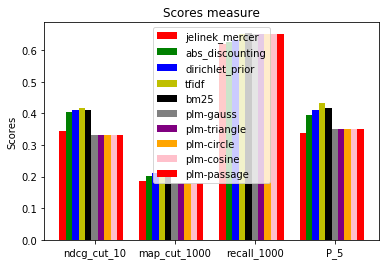

jelinek_mercer


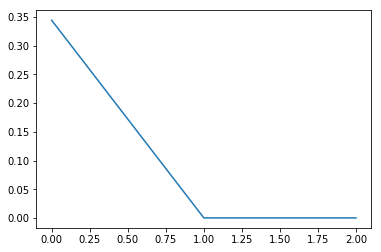

abs_discounting


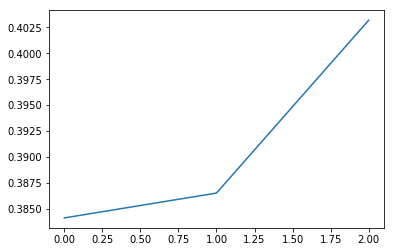

dirichlet_prior


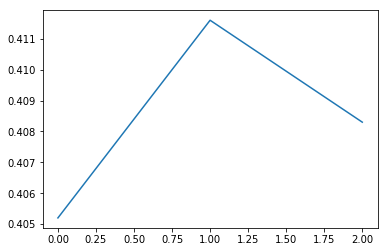

tfidf


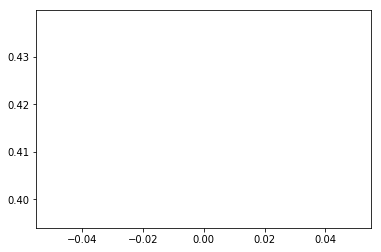

bm25


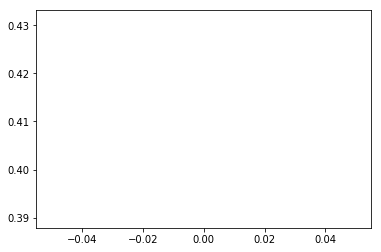

plm-gauss


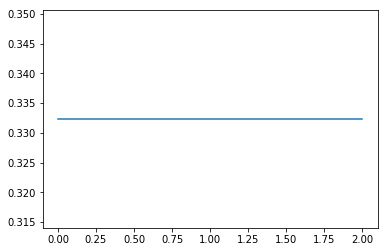

plm-triangle


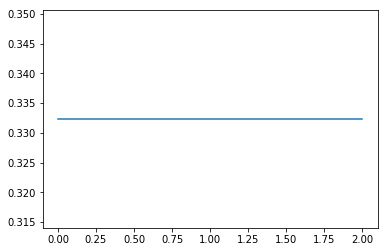

plm-circle


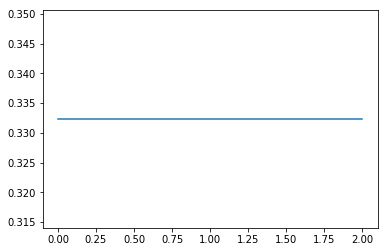

plm-cosine


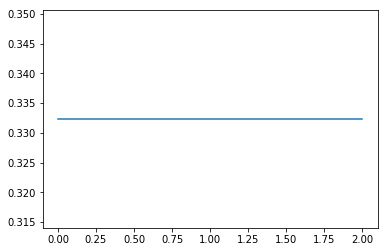

plm-passage


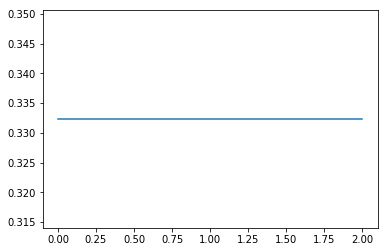

In [30]:
from collections import defaultdict
import os
import scipy.stats
import matplotlib.pyplot as plt

def validation_best(score_name, param_list, measures):
    result_dicts = []
    for p in param_list:
        
        result_dicts.append(trec_eval(score_name + ('_' + str(p) if p != None else ''), measures, validation=True))
    vals = []
    for res in result_dicts:
#         print(res)
        vals.append(res['ndcg_cut_10']['all'])
    best = np.argmax(vals)
    return best, vals[best], param_list[best], result_dicts[best], result_dicts
    
def trec_eval(score_name, measures, validation=True):
    validation_str = 'validation' if validation else 'test'
    results = defaultdict(dict)
    a = os.system(str.format('./trec_eval/trec_eval -m all_trec -q ap_88_89/qrel_{} {}.run > trec_results_{}', validation_str, score_name, score_name))
    f = open('results/trec_results_' + score_name, 'r')
    for line in f.readlines():
        name, id, val = line.strip().split()
        if name in measures:
            val = float(val)
            results[name][id] = val

    f.close()
    return results

kernel_names = ['gauss', 'triangle', 'circle', 'cosine', 'passage']
measures = ['ndcg_cut_10', 'map_cut_1000', 'recall_1000', 'P_5']
scores = ['jelinek_mercer','abs_discounting', 'dirichlet_prior', 'tfidf', 'bm25']
plm_names = ['plm-' + kernel_name for kernel_name in kernel_names]

scores = scores + plm_names
params = {'jelinek_mercer': [0.1, 0.5, 0.9],
         'abs_discounting': [0.1, 0.5, 0.9],
         'dirichlet_prior': [500, 1000, 1500],
          'tfidf': [None], 'bm25': [None]}
for i, name in enumerate(plm_names):
    params[name] = [0.1, 0.5, 0.9]
    
ind = np.arange(len(measures))
width = 0.08
colors = ['r', 'g', 'b', 'y', 'k', 'grey', 'purple', 'orange', 'pink']
colors = colors + colors + colors + colors
fig, ax = plt.subplots()
rs = []
#evaluation measures on with optimized hyper parameters
bests = dict()
for i, score in enumerate(scores):
    best, best_val, best_param, best_result, results = validation_best(score, params[score], measures)
    bests[score] = best_param
    means = [best_result[measure]['all'] for measure in measures]
    rs.append(ax.bar(ind + width*i, means, width, color=colors[i]))
# print(bests)
ax.legend(rs, scores)
ax.set_ylabel('Scores')
ax.set_title('Scores measure')
ax.set_xticks(ind + width*10 / 2)
ax.set_xticklabels(measures)
plt.show()


ind = np.arange(3)
width = 0.08
fig, ax = plt.subplots()
rs = []
result_dicts = defaultdict(dict)
for i, score in enumerate(scores):
#     if score in params:
    for p in params[score]:
        result_dicts[score][p] = trec_eval(score + ('_' + str(p) if p != None else ''), measures, validation=False)
#     else:
#         print('we')
#         results_dicts[score][None] = trec_eval(score, measures, validation=False)
#     print(result_dicts[score])
    means = [result_dicts[score][p]['ndcg_cut_10']['all'] for p in result_dicts[score]]
    print(score)
    markers_on = [i for i, _ in enumerate(params[score])]
    plt.plot(means, markevery=markers_on)
    plt.show()

In [31]:
import pandas
pairwise = defaultdict(dict)
for score in scores:
    for score2 in scores:
        pairwise[score][score2] = scipy.stats.ttest_rel(list(result_dicts[score][bests[score]]['ndcg_cut_10'].values()), 
                                     list(result_dicts[score2][bests[score2]]['ndcg_cut_10'].values()))
        # here we should compare to our p value to decide the significance
#         print('result of ', score, ' with score ', param, 'respect to ', score2, 'is ', a, p)
df = pandas.DataFrame.from_dict(pairwise)        
print(df)

                                             abs_discounting  \
abs_discounting                                   (nan, nan)   
bm25               (-0.5257236903056055, 0.6000503635431209)   
dirichlet_prior     (-0.820053427200254, 0.4138115557777783)   
jelinek_mercer   (3.5410519528295255, 0.0005682863686325523)   
plm-circle        (4.872483344675144, 3.404494295037945e-06)   
plm-cosine        (4.872483344675144, 3.404494295037945e-06)   
plm-gauss         (4.872483344675144, 3.404494295037945e-06)   
plm-passage       (4.872483344675144, 3.404494295037945e-06)   
plm-triangle      (4.872483344675144, 3.404494295037945e-06)   
tfidf             (-0.8849352885444004, 0.37796127448567174)   

                                                        bm25  \
abs_discounting     (0.5257236903056055, 0.6000503635431209)   
bm25                                              (nan, nan)   
dirichlet_prior   (-0.11174077747120753, 0.9112156386153231)   
jelinek_mercer   (5.652313301359162, 1.

In [23]:
for score1 in scores:
    res1 = result_dicts[score1][bests[score1]]
    values1 = list(sorted(res1['P_5'].items(), key=lambda t: t[1], reverse=True))
    for score in scores:
        res = result_dicts[score][bests[score]]
        values = list(sorted(res['P_5'].items(), key=lambda t: t[1], reverse=True))
        v1 = [s for s, _ in values1[:20]]
        v = [s for s, _ in values[-40:]]
        newset = set(v1) & set(v)
        if len(newset) > 0:
            print([dictionary.id2token[int(tok)] for a in newset for tok in tokenized_queries[a]], score1, score)
        

['health', 'hazards', 'fine', 'diameter', 'fibers'] jelinek_mercer abs_discounting
['black', 'resistance', 'south', 'african', 'government'] abs_discounting jelinek_mercer
['black', 'resistance', 'south', 'african', 'government'] dirichlet_prior jelinek_mercer
['laser', 'research', 'applicable', 'u', 's', 's', 'strategic', 'defense', 'initiative'] bm25 jelinek_mercer
['laser', 'research', 'applicable', 'u', 's', 's', 'strategic', 'defense', 'initiative'] bm25 abs_discounting
['laser', 'research', 'applicable', 'u', 's', 's', 'strategic', 'defense', 'initiative'] bm25 dirichlet_prior


### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

In [20]:
num_topics = [10, 25, 50]

In [21]:
# import numpy as np
import gensim
from scipy import spatial



# for the LdaModel the corpus should be a list of docs, where each document is represented as a list of tuples, 
# where a tuple means a word and occurence
my_corpus = []

# iterate over the documents
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    doc_token_ids = [doc_token_id for doc_token_id in doc_token_ids if doc_token_id > 0]
    document_bow = collections.Counter(doc_token_ids).most_common(len(doc_token_ids))
    my_corpus.append(document_bow)


KeyboardInterrupt: 

1

In [20]:
def train_lda(num_topics):
    for num in num_topics:
        lda_model = gensim.models.LdaModel(my_corpus, id2word=id2token, minimum_probability=0, alpha='auto', num_topics=num)
        lda_model.save('Lda_model_'+str(num)+'.lda')


In [21]:
def train_lsi(num_topics):
    for num in num_topics:
        lsi_model = gensim.models.LsiModel(my_corpus, id2word=id2token, num_topics=num)
        lsi_model.save('Lsi_model_'+str(num)+'.lsi')
        


In [ ]:
# train_lsi(num_topics)

In [ ]:
# train_lda(num_topics)

In [24]:
# input parameters: number of topics, topic name
def load_model_lda(num, model_name):
    model = gensim.models.LdaModel.load(model_name+'_'+num+'.lda')
    return model
def load_model_lsi(num, model_name):
    model = gensim.models.LsiModel.load(model_name+'_'+num+'.lsi')
    return model

In [25]:
lsi_models = {}
# model = gensim.models.LsiModel.load('Lda_model'+'.lda')

for num in num_topics:
    lsi_models[num] = load_model_lsi(str(num), 'Lsi_model')

lda_models = {}
for num in num_topics:
    lda_models[num] = load_model_lda(str(num), 'Lda_model')
print(lda_models)

{10: <gensim.models.ldamodel.LdaModel object at 0x7f775213e3c8>, 25: <gensim.models.ldamodel.LdaModel object at 0x7f77458cf3c8>, 50: <gensim.models.ldamodel.LdaModel object at 0x7f774410fc50>}


In [24]:
lda_models[10].print_topics(4, 10)

[(2,
  '0.009*"west" + 0.008*"israel" + 0.008*"israeli" + 0.008*"iran" + 0.007*"war" + 0.006*"army" + 0.006*"arab" + 0.006*"iranian" + 0.006*"two" + 0.005*"palestinian"'),
 (9,
  '0.017*"soviet" + 0.011*"government" + 0.010*"people" + 0.007*"000" + 0.006*"military" + 0.005*"party" + 0.005*"union" + 0.005*"officials" + 0.005*"miles" + 0.005*"fire"'),
 (4,
  '0.012*"president" + 0.011*"bush" + 0.010*"dukakis" + 0.007*"reagan" + 0.006*"campaign" + 0.006*"states" + 0.006*"new" + 0.006*"united" + 0.005*"democratic" + 0.005*"party"'),
 (8,
  '0.005*"new" + 0.005*"people" + 0.004*"years" + 0.003*"old" + 0.003*"two" + 0.003*"time" + 0.003*"home" + 0.003*"city" + 0.003*"says" + 0.002*"dont"')]

In [25]:
(lsi_models[10].print_topics(9,115))

[(0,
  '0.296*"percent" + 0.200*"new" + 0.199*"1" + 0.177*"million" + 0.144*"two" + 0.140*"000" + 0.138*"people" + 0.135*"government" + 0.130*"president" + 0.126*"2" + 0.120*"years" + 0.106*"bush" + 0.104*"state" + 0.098*"5" + 0.097*"states" + 0.095*"3" + 0.092*"billion" + 0.088*"time" + 0.085*"three" + 0.082*"officials" + 0.080*"united" + 0.080*"4" + 0.080*"soviet" + 0.076*"national" + 0.074*"10" + 0.073*"house" + 0.071*"6" + 0.068*"federal" + 0.067*"police" + 0.067*"american" + 0.066*"0" + 0.064*"party" + 0.063*"7" + 0.062*"told" + 0.061*"8" + 0.060*"today" + 0.059*"york" + 0.058*"made" + 0.058*"says" + 0.058*"tuesday" + 0.057*"say" + 0.057*"west" + 0.055*"city" + 0.055*"report" + 0.055*"company" + 0.054*"court" + 0.054*"department" + 0.054*"wednesday" + 0.053*"news" + 0.053*"market" + 0.053*"dukakis" + 0.053*"monday" + 0.053*"thursday" + 0.051*"month" + 0.051*"did" + 0.050*"military" + 0.050*"friday" + 0.049*"old" + 0.049*"12" + 0.049*"prices" + 0.049*"9" + 0.048*"union" + 0.048*"fo

In [30]:
# input: pretrained model
# output: representation of all the documents based on the pretrained model
def create_repr_for_docs(model):
    docs_repr = []
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)
        doc_token_ids = [doc_token_id for doc_token_id in doc_token_ids if doc_token_id > 0]
        document_bow = collections.Counter(doc_token_ids).most_common(len(doc_token_ids))
        docs_repr.append(model[document_bow])
    return docs_repr

In [32]:
for idx, i in enumerate(create_repr_for_docs(lsi_models[10])):
    if len(i) < 10:
        print(idx, i)

93687 []
102434 []
104039 []
121862 []
121865 []
122112 []
147903 []
149904 []
153511 []
154466 []
155653 []


In [25]:
import pandas as pd

In [ ]:

lda_doc_repr = {}
for num in num_topics:
    print(num)
    lda_doc_repr[num] = create_repr_for_docs(lda_models[num])
    df = pd.DataFrame(lda_doc_repr[num])
    df.to_csv('lda_doc_repr_{}.csv'.format(num))

In [ ]:
lsi_doc_repr = {}
for num in num_topics:
    print(num)
    lsi_doc_repr[num] = create_repr_for_docs(lsi_models[num])
# pickle.dump(lsi_doc_repr, open('lsi_doc_repr.pkl', 'wb'))
    df = pd.DataFrame(lsi_doc_repr[num])
    df.to_csv('lsi_doc_repr_{}.csv'.format(num))

In [22]:
import csv
from collections import defaultdict

def to_tuple(arr):
    res_arr = []
    tup = ()
    for item in arr:
        try:
            tup = tuple([float(i.strip()) for i in item.replace('(', '').replace(')','').split(',')])
        except Exception:
            print(item)
        res_arr.append(tup)
    return res_arr

lsi_doc_repr = {}
lda_doc_repr = {}
for num in num_topics:
    document_ids = {}
    with open('lsi_doc_repr_{}.csv'.format(num), 'r') as csvin:
        reader=csv.DictReader(csvin)
        data = defaultdict(list)
        for i, line in enumerate(reader):
            tuples = to_tuple(list(line.values())[1:])
            document_ids[i] = tuples
    lsi_doc_repr[num] = document_ids

    document_ids = {}
    with open('lda_doc_repr_{}.csv'.format(num), 'r') as csvin:
        reader=csv.DictReader(csvin)
        data = defaultdict(list)
        for i, line in enumerate(reader):
            tuples = to_tuple(list(line.values())[1:])
            document_ids[i] = tuples
    lda_doc_repr[num] = document_ids

# lsi_doc_repr = pickle.load(open('lsi_doc_repr.pkl', 'rb'))
# lda_doc_repr = pickle.load(open('lda_doc_repr.pkl', 'rb'))

In [78]:
len(lda_doc_repr[10])

164597

In [32]:
print(len(lsi_doc_repr[10]))

11


In [27]:
def cos_similarity(a, b):
    # Input: dense representation(a list) of the document and query 
    # Output: cosine similarity between the vectors 
    
    cos_sim = 1 - spatial.distance.cosine(a, b)
    return cos_sim

In [28]:
# print(query_term_counts['51'].most_common(len(query_term_counts['51'])))
import numpy as np
lda_data = {}
lsi_data = {}

def get_data(lda_model, lda_docs):
    # loop through all the queries
    data = collections.defaultdict(list)
    for query_id in tokenized_queries:
        print(query_id)
        # convert the queries into format that is needed for lda
        query_count_list = query_term_counts[query_id].most_common(len(query_term_counts[query_id]))
        # calculate the lda representation of the query
        query_lda = lda_model[query_count_list]
        # convert it to vector format []
        a = [x[1] for x in query_lda]
        # take the 1000 most relevant docs for the query (based on tf-idf)
        most_relevant_doc_ids = top_1000[int(query_id)]
        for idx in most_relevant_doc_ids:
            try:
                b = [x[1] for x in lda_docs[idx] if len(x) > 0 else []]
            except Exception:
                print(idx)
                print(lda_docs[idx])
            ext_doc_id, _ = index.document(int_doc_id)
#             print(a, b)
#             print(cos_similarity(a,b))
            data[query_id].append((cos_similarity(a, b), ext_doc_id))
    return data


for param in lda_models:
    print('paraaaaaaaam ', param)

    lda_data[param] = get_data(lda_models[param], lda_doc_repr[param])
    
    run_out_path = 'results/{}_{}.run'.format('lda_model', str(param))
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name='{}_{}'.format('lda_model', str(param)),
            data=lda_data[param],
            out_f=f_out,
            max_objects_per_query=1000)
    print('start lsi --------------')
    
    lsi_data[param] = get_data(lsi_models[param], lsi_doc_repr[param])
        
    run_out_path = 'results/{}_{}.run'.format('lsi_model', str(param))
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name='{}_{}'.format('lsi_model', str(param)),
            data=lsi_data[param],
            out_f=f_out,
            max_objects_per_query=1000)

paraaaaaaaam  10
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
start lsi --------------
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
122112
[(), (), (), (), (), (), (), (), (), ()]
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
147903
[(), (), (), (), (), (), (), (), (), ()]
89
155653
[(), (), (), (), (), (), (), (), (), ()]
90
91
92
93
94
93687
[(), (), (), (), (), (), (), (), (), ()]
95
93687
[(), (), (), (), (), (), (), (), (), ()]
96
93687
[(), (), (), (), (), (), 

In [82]:
lsi_doc_repr[10][66]

[(0.0, 2.43511247185543),
 (1.0, 1.6709289118360229),
 (2.0, -0.07712911431410227),
 (3.0, -0.44934658026194746),
 (4.0, -1.022170530923021),
 (5.0, 0.206544369402953),
 (6.0, -0.5209321772340828),
 (7.0, -0.02460256922085409),
 (8.0, -0.2149024602588037),
 (9.0, 0.02138008749107591)]

In [50]:
df = pd.read_csv('lda_doc_repr_{}.csv'.format(num))
pd.to_numeric(df[1])
# doc_repr_dict = {}
# for i, arr in enumerate(df.iloc[:, 1:].head().as_matrix()):
#     doc_repr_dict[i] = [arr

KeyError: 1

In [70]:


# def fitem(item):
#     item=item.strip()
#     try:
#         item=float(item)
#     except ValueError:
#         pass
#     return item        

i = 0
all_docs_repr[]

# print(dict(data)) 
# print(to_tuple(['(0, 0.13)', '(0, 0.1)']))

[(0.0, 0.03171322), (1.0, 0.12633656), (2.0, 0.0002290061), (3.0, 0.026066173), (4.0, 0.00066875515), (5.0, 0.40222794), (6.0, 0.016766768), (7.0, 0.32275137), (8.0, 0.0365312), (9.0, 0.03670898)]
[(0.0, 0.14949264), (1.0, 0.013563194), (2.0, 0.00029685284), (3.0, 0.0005808906), (4.0, 0.72318363), (5.0, 0.0116111245), (6.0, 0.0005854682), (7.0, 0.0005045803), (8.0, 0.05133185), (9.0, 0.04884978)]
[(0.0, 0.0023358585), (1.0, 0.013371393), (2.0, 0.0010398861), (3.0, 0.0020367263), (4.0, 0.17232288), (5.0, 0.29906815), (6.0, 0.108317874), (7.0, 0.0017673819), (8.0, 0.20281765), (9.0, 0.19692223)]
[(0.0, 0.002359575), (1.0, 0.002118388), (2.0, 0.0010560027), (3.0, 0.05008334), (4.0, 0.00304759), (5.0, 0.0023994972), (6.0, 0.002078374), (7.0, 0.2440935), (8.0, 0.69103104), (9.0, 0.0017326717)]
[(0.0, 0.00061672943), (1.0, 0.20337461), (2.0, 0.00027526563), (3.0, 0.011124012), (4.0, 0.04326093), (5.0, 0.0006279241), (6.0, 0.0005423719), (7.0, 0.00046763802), (8.0, 0.739259), (9.0, 0.00045153

### Task 3:  Word embeddings for ranking [10 points] ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).

Try one of the following (increasingly complex) methods for building query and document representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248).
   
Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [ ]:
%%time
import copy
import gensim
import logging
import pyndri
import pyndri.compat
import sys


word2vec_init = gensim.models.Word2Vec(
    size=300,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=5,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)

with pyndri.open('index/') as index:
    logging.info('Loading vocabulary.')
    dictionary = pyndri.extract_dictionary(index)
    sentences = pyndri.compat.IndriSentences(index, dictionary)

    logging.info('Constructing word2vec vocabulary.')

    # Build vocab.
    word2vec_init.build_vocab(sentences, trim_rule=None)
#     print(len(word2vec_init.corpus_count))
#     print(len(dictionary))
#     print(len(sentences))
    models = [word2vec_init]

    for epoch in range(1, 5 + 1):
        logging.info('Epoch %d', epoch)

        model = copy.deepcopy(models[-1])
        model.train(sentences, total_examples=len(sentences), epochs=model.iter)

        models.append(model)

    logging.info('Trained models: %s', models)

### Task 4: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval, in particular pointwise learning to rank.

You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1 and Task 2 as features. Think about other features you can use (e.g. query/document length). 
One idea is to also explore external sources such as Wikipedia entities (?). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

In [ ]:
score = 'tfidf'
measures = ['P_5']
ranking = trec_eval(score + '_' + str(p), measures, validation=False)
# sort and get the top 1000, using which score?
print(ranking['P_5'])



### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
